In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime WARNINGS, muestra solo errores

In [13]:
# Define latent dimension and input shape
latent_dim = 50
input_shape = (32, 32, 3)

In [14]:
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # TODO: Add a Conv2D layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 32, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(inputs)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    # TODO: Add a Conv2D layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2D(
        strides = 1,
        filters = 16, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)

    
    x = Conv2D(
        strides = 1,
        filters = 8, 
        kernel_size=(3,3),
        activation='relu',
        padding='same'
    )(x)
    
    x = MaxPooling2D((2,2), padding='same')(x)


    # TODO: Save the shape before flattening for use in the decoder (e.g., shape_before_flattening = ?)
    shape_before_flattening = x.shape

    # TODO: Flatten the output
    x = Flatten()(x)

    # TODO: Add a Dense layer to produce the latent vector of dimension latent_dim
    # (assign the output of this Dense layer to a variable named "latent")
    latent = Dense(units= latent_dim, activation= 'relu')(x)

    encoder = Model(inputs, latent, name="encoder")
    return encoder, shape_before_flattening


In [15]:
def build_decoder(latent_dim, shape_before_flattening):
    latent_inputs = Input(shape=(latent_dim,))

    # TODO: Add a Dense layer to expand the latent vector back to the size of the flattened feature map
    x = Dense(
        np.prod(
            shape_before_flattening[1:]
        ),
        activation='relu'
    )(latent_inputs)

    # TODO: Reshape the expanded vector back to the shape before flattening
    x = Reshape(shape_before_flattening[1:])(x)

    # TODO: Add a Conv2DTranspose layer with 8 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 8,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2DTranspose(
        filters= 16,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a Conv2DTranspose layer with 16 filters, kernel size (3,3), activation 'relu', strides=1, and padding 'same'
    x = Conv2DTranspose(
        filters= 32,
        kernel_size=(3,3),
        strides=1,
        activation='relu',
        padding='same'
    )(x)
    x = UpSampling2D((2,2))(x)

    # TODO: Add a final Conv2D layer with 3 filters, kernel size (1,1), activation 'sigmoid', and padding 'same'
    # (assign the output of this layer to a variable named "outputs")
    outputs = Conv2DTranspose(
        filters= 3,
        kernel_size=(3,3),
        activation='sigmoid',
        padding='same'
    )(x)

    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

In [16]:
# Build encoder and decoder
encoder, shape_before_flattening = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, shape_before_flattening)

# Create the full autoencoder by connecting encoder and decoder
input_img = Input(shape=input_shape)
latent_repr = encoder(input_img)
reconstructed_img = decoder(latent_repr)
autoencoder = Model(input_img, reconstructed_img, name="autoencoder")

# TODO: Compile the autoencoder with an optimizer (e.g., Adam) and a loss function (e.g., 'binary_crossentropy')
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 50)             │        13,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │        13,787 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,917 (105.14 KB)

 Trainable params: 26,917 (105.14 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Load CIFAR-10 data and normalize pixel values to [0, 1]
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

In [18]:
# training
autoencoder.fit(
    x_train, x_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose = 1
)

Epoch 1/100


I0000 00:00:1740203841.978139    7245 service.cc:148] XLA service 0x70218400f570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740203841.978283    7245 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-02-21 23:57:22.049932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740203842.348863    7245 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-02-21 23:57:23.062589: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 52 bytes spill stores, 52 bytes spill loads

2025-02-21 23:57:23.289427: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377',

 18/196 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0713

I0000 00:00:1740203847.190715    7245 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


193/196 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0538

2025-02-21 23:57:30.150388: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 260 bytes spill stores, 260 bytes spill loads

2025-02-21 23:57:30.406165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_948', 216 bytes spill stores, 216 bytes spill loads

2025-02-21 23:57:30.732873: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_377', 100 bytes spill stores, 100 bytes spill loads



196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0.0535 - val_loss: 0.0288
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0271 - val_loss: 0.0244
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0229 - val_loss: 0.0209
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0204 - val_loss: 0.0198
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0189 - val_loss: 0.0186
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0180 - val_loss: 0.0178
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0175 - val_loss: 0.0174
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


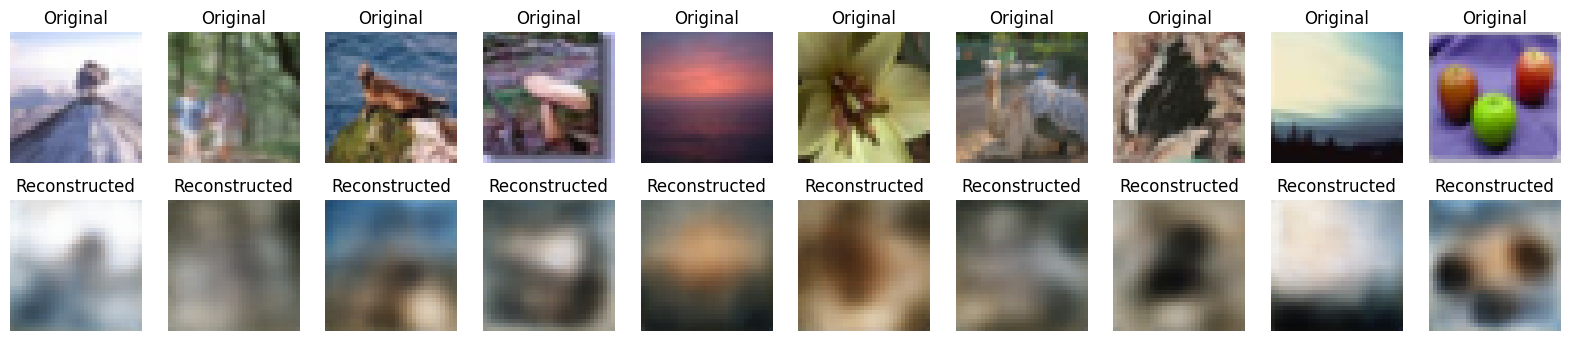

In [19]:
# Reconstruct images from the test set
decoded_imgs = autoencoder.predict(x_test)

# Visualize original and reconstructed images side by side
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()